In [ ]:
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,BatchNormalization
from tensorflow.keras.optimizers.legacy import Adamax
from keras.metrics import AUC
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve

In [ ]:
def data(path):
    classes = []
    class_paths = []
    files = os.listdir(path)
    for file in files:
        label_dir = os.path.join(path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Labels')
    image_paths = pd.Series(class_paths, name='Paths')
    df = pd.concat([image_paths, image_classes], axis=1)
    return df

In [ ]:
tr_df = data("archive/Training")

In [ ]:
ts_df = data("archive/Test")

In [ ]:
tr_df.shape

(5712, 2)

In [ ]:
tr_df.head()

,Paths,Labels
0,archive/Training/pituitary/Tr-pi_0505.jpg,pituitary
1,archive/Training/pituitary/Tr-pi_0263.jpg,pituitary
2,archive/Training/pituitary/Tr-pi_0277.jpg,pituitary
3,archive/Training/pituitary/Tr-pi_1169.jpg,pituitary
4,archive/Training/pituitary/Tr-pi_0511.jpg,pituitary


In [ ]:
ts_df.shape

(1311, 2)

In [ ]:
ts_df.head()

,Paths,Labels
0,archive/Test/pituitary/Te-pi_0233.jpg,pituitary
1,archive/Test/pituitary/Te-pi_0227.jpg,pituitary
2,archive/Test/pituitary/Te-pi_0019.jpg,pituitary
3,archive/Test/pituitary/Te-pi_0031.jpg,pituitary
4,archive/Test/pituitary/Te-pi_0025.jpg,pituitary


In [ ]:
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 123)
print(valid_df.shape)
print(test_df.shape)

(655, 2)
(656, 2)


In [ ]:
batch_size = 64
img_size = (224, 224)

In [ ]:
idg = ImageDataGenerator(rescale=1./255)

In [ ]:
train = idg.flow_from_dataframe(tr_df, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical',
                                 shuffle = True, batch_size = batch_size)


Found 5712 validated image filenames belonging to 4 classes.


In [ ]:
train_labels=train.classes

In [ ]:
valid = idg.flow_from_dataframe(valid_df, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical',
                                   shuffle = True, batch_size = batch_size)

Found 655 validated image filenames belonging to 4 classes.


In [ ]:
valid_labels=valid.classes

In [ ]:
test = idg.flow_from_dataframe(test_df, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical',
                                 shuffle = False, batch_size = batch_size)

Found 656 validated image filenames belonging to 4 classes.


In [ ]:
test_labels=test.classes
#test_labels

In [ ]:
class_index = train.class_indices
class_index

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
Keys = list(class_index.keys())
Keys

['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
imgs, labels = next(train)

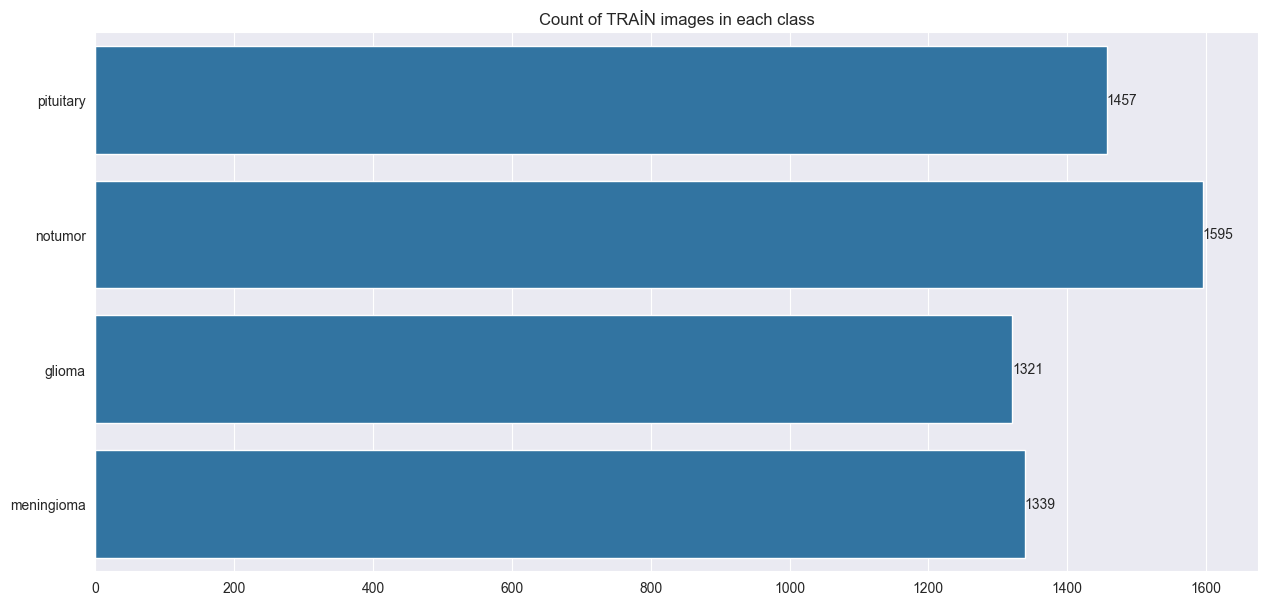

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Labels'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of TRAİN images in each class', fontsize=12)
ax.bar_label(ax.containers[0])
plt.show()

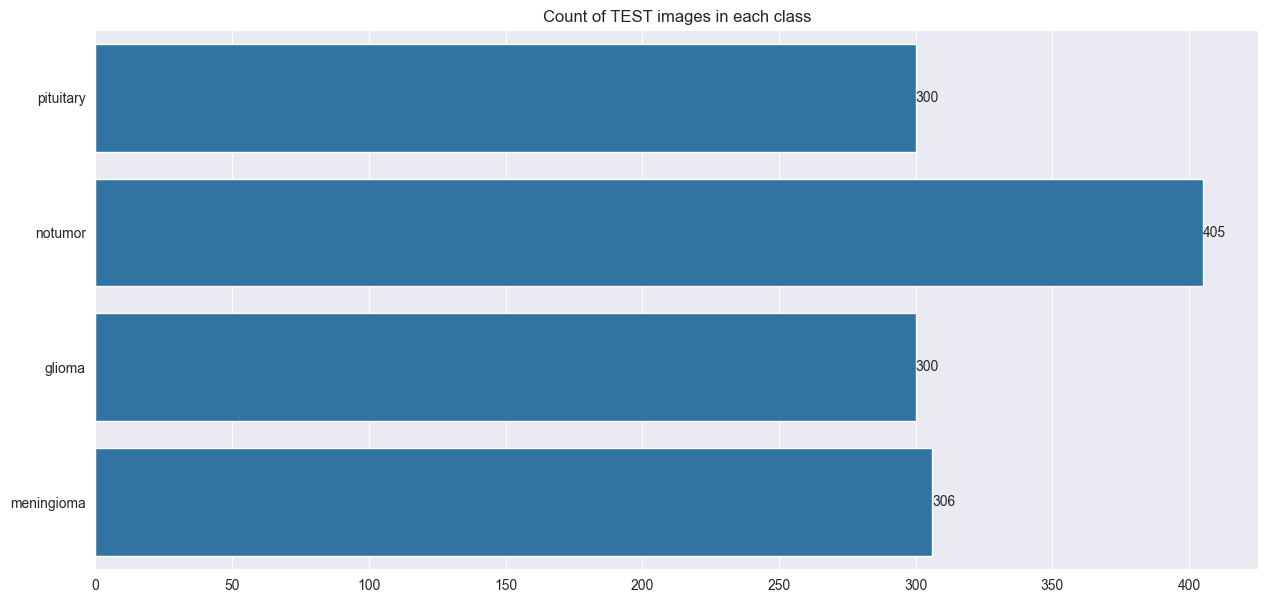

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df , y=ts_df['Labels'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of TEST images in each class', fontsize=12)
ax.bar_label(ax.containers[0])
plt.show()

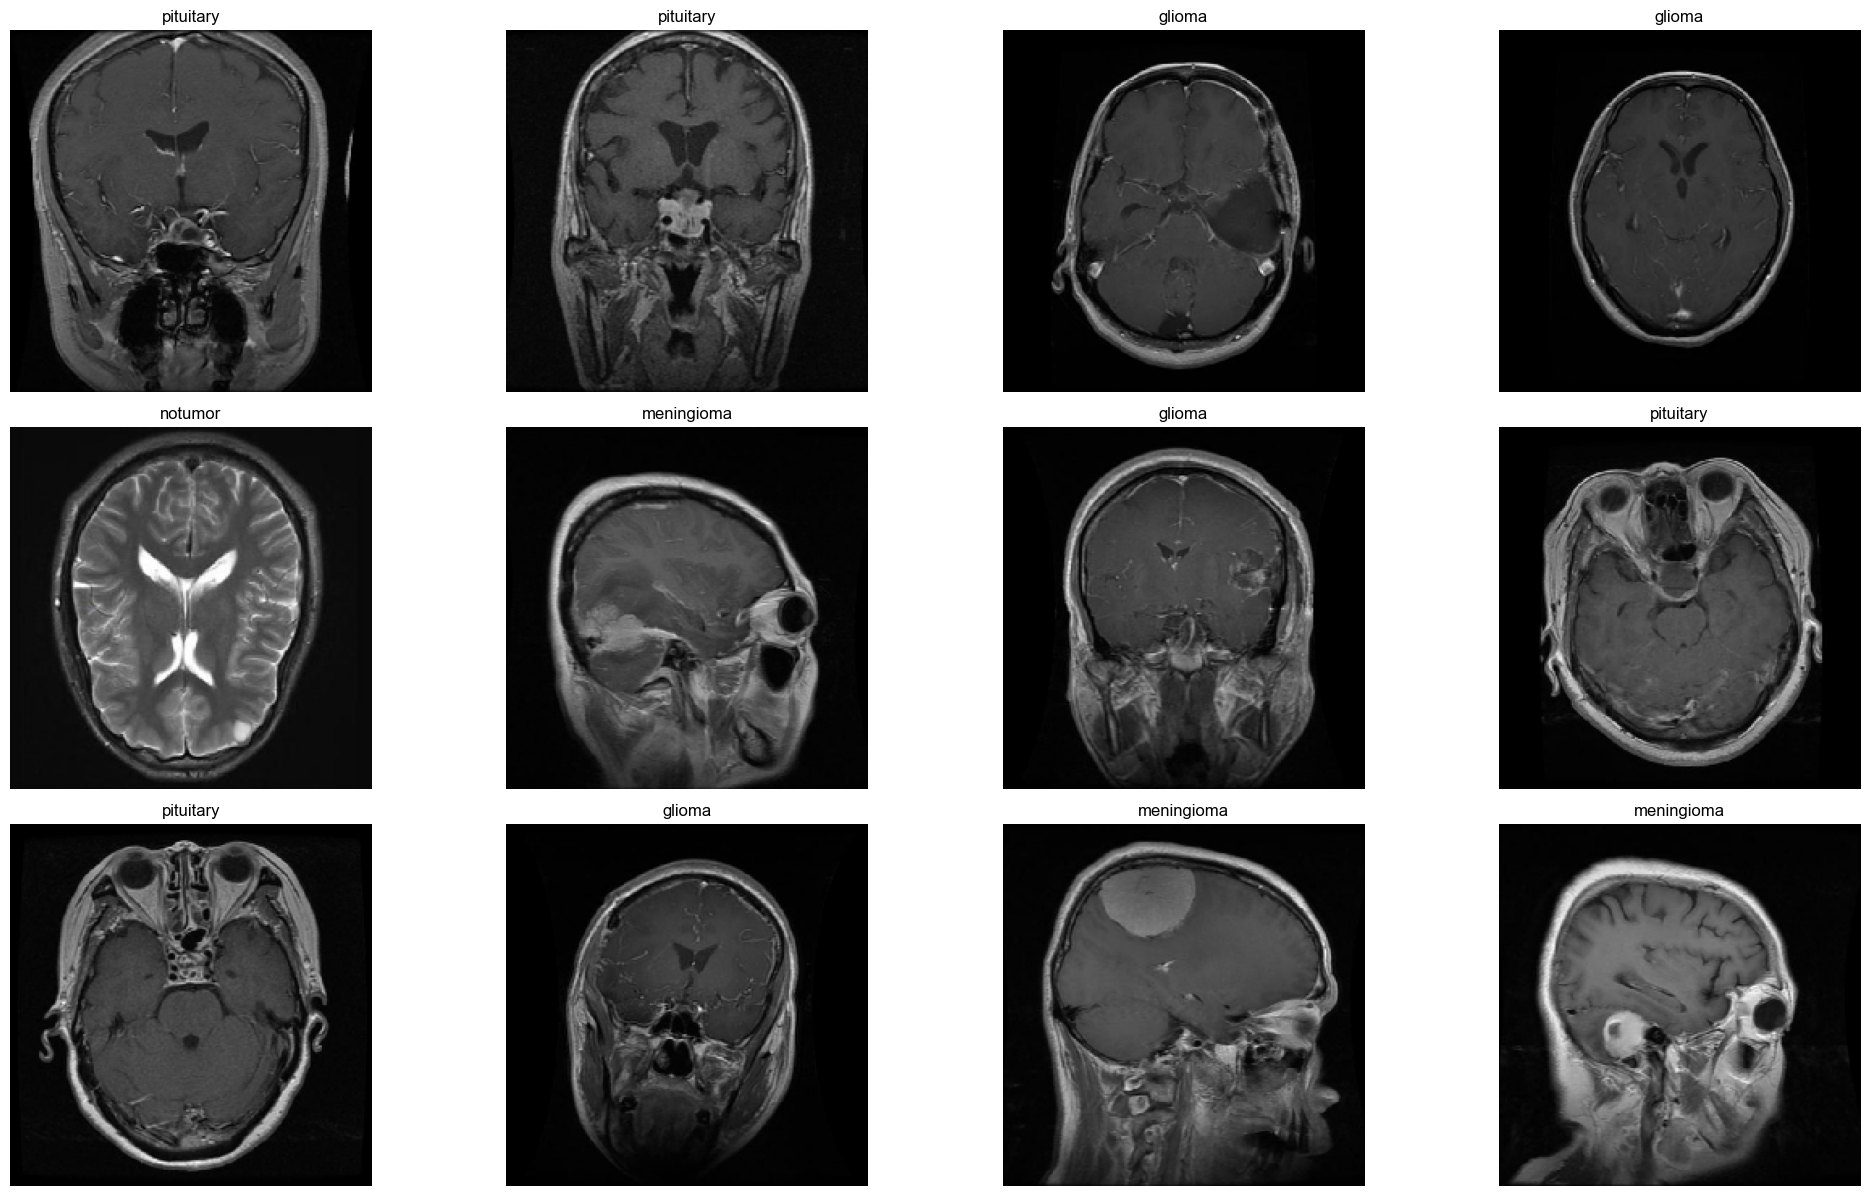

In [ ]:
plt.figure(figsize= (20, 20))

for i in range(12):
    plt.subplot(5, 4, i +1)
    im = imgs[i]
    plt.imshow(im)
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'black')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model = Sequential()

# Conv2D-1
model.add(Conv2D(32, (1, 1), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization(axis=-1))
# Conv2D-2
model.add(Conv2D(64, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
# Conv2D-3
model.add(Conv2D(64, (2, 2), activation='relu'))
# Conv2D-4
model.add(Conv2D(64, (3, 3), activation='relu'))
# Conv2D-5
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
# Conv2D-6
model.add(Conv2D(128, (3, 3), activation='relu'))
# Conv2D-7
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
# FC-1
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
# FC-2
model.add(Dense(4, activation='softmax'))


In [ ]:
opt = tf.keras.optimizers.legacy.Adamax(learning_rate=0.001)

In [ ]:
#model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = 'accuracy')

In [ ]:
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics=[AUC(name='auc')])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 224, 224, 32)      128       
                                                                 
 batch_normalization_12 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_22 (Conv2D)          (None, 224, 224, 64)      2112      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_13 (Ba  (None, 112, 112, 64)      256       
 tchNormalization)                                               
                                                      

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
history_acc = model.fit(x = train, epochs = 20, verbose = 1, validation_data = valid, shuffle = False)

In [ ]:
#auc fit
history = model.fit(x = train, epochs = 20, verbose = 1, validation_data = valid, shuffle = False)

Epoch 1/20
90/90 [==============================] - 263s 3s/step - loss: 0.9795 - auc: 0.9390 - val_loss: 31.1882 - val_auc: 0.4718
Epoch 2/20
90/90 [==============================] - 261s 3s/step - loss: 0.2565 - auc: 0.9875 - val_loss: 30.2572 - val_auc: 0.4718
Epoch 3/20
90/90 [==============================] - 260s 3s/step - loss: 0.1577 - auc: 0.9952 - val_loss: 12.1197 - val_auc: 0.4854
Epoch 4/20
90/90 [==============================] - 275s 3s/step - loss: 0.0946 - auc: 0.9985 - val_loss: 6.5861 - val_auc: 0.5694
Epoch 5/20
90/90 [==============================] - 263s 3s/step - loss: 0.0529 - auc: 0.9996 - val_loss: 2.8822 - val_auc: 0.6988
Epoch 6/20
90/90 [==============================] - 252s 3s/step - loss: 0.0337 - auc: 0.9999 - val_loss: 1.2547 - val_auc: 0.8724
Epoch 7/20
90/90 [==============================] - 267s 3s/step - loss: 0.0246 - auc: 1.0000 - val_loss: 0.6453 - val_auc: 0.9512
Epoch 8/20
90/90 [==============================] - 264s 3s/step - loss: 0.0156 

In [ ]:
tr_acc = history_acc.history_acc['accuracy']
tr_loss = history_acc.history_acc['loss']

v_acc = history_acc.history_acc['val_accuracy']
v_loss = history_acc.history_acc['val_loss']

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]
index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

In [ ]:
print(Epochs)
print(tr_acc)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.7853641510009766, 0.9191176295280457, 0.9536064267158508, 0.975665271282196, 0.9893207550048828, 0.9952731132507324, 0.9975489974021912, 0.9992997050285339, 0.9994747638702393, 0.9998249411582947, 0.9998249411582947, 0.9992997050285339, 0.9989495873451233, 0.9980742335319519, 0.9996498823165894, 1.0, 0.9998249411582947, 0.9998249411582947, 1.0, 1.0]


In [ ]:
tr_auc = history.history['auc']
tr_loss_auc = history.history['loss']

v_auc = history.history['val_auc']
v_loss_auc = history.history['val_loss']

index_auc = np.argmax(v_auc)
high_Vauc = v_auc[index_auc]
index_loss_auc = np.argmin(v_loss_auc)
low_Vloss_auc = v_loss_auc[index_loss_auc]

Epochs =[]
for i in range(len(tr_auc)):
    Epochs.append (i+1)

best_auc = f'Best epoch ={str(index_auc +1)}'
best_loss = f'Best epoch ={str(index_loss_auc+1)}'


In [ ]:
print(Epochs)
print(tr_auc)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.9390122890472412, 0.987519383430481, 0.9952139258384705, 0.9984821677207947, 0.9996251463890076, 0.9998902082443237, 0.9999587535858154, 0.999995231628418, 0.9999988675117493, 1.0, 0.9997274279594421, 0.9999986290931702, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0]


In [ ]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

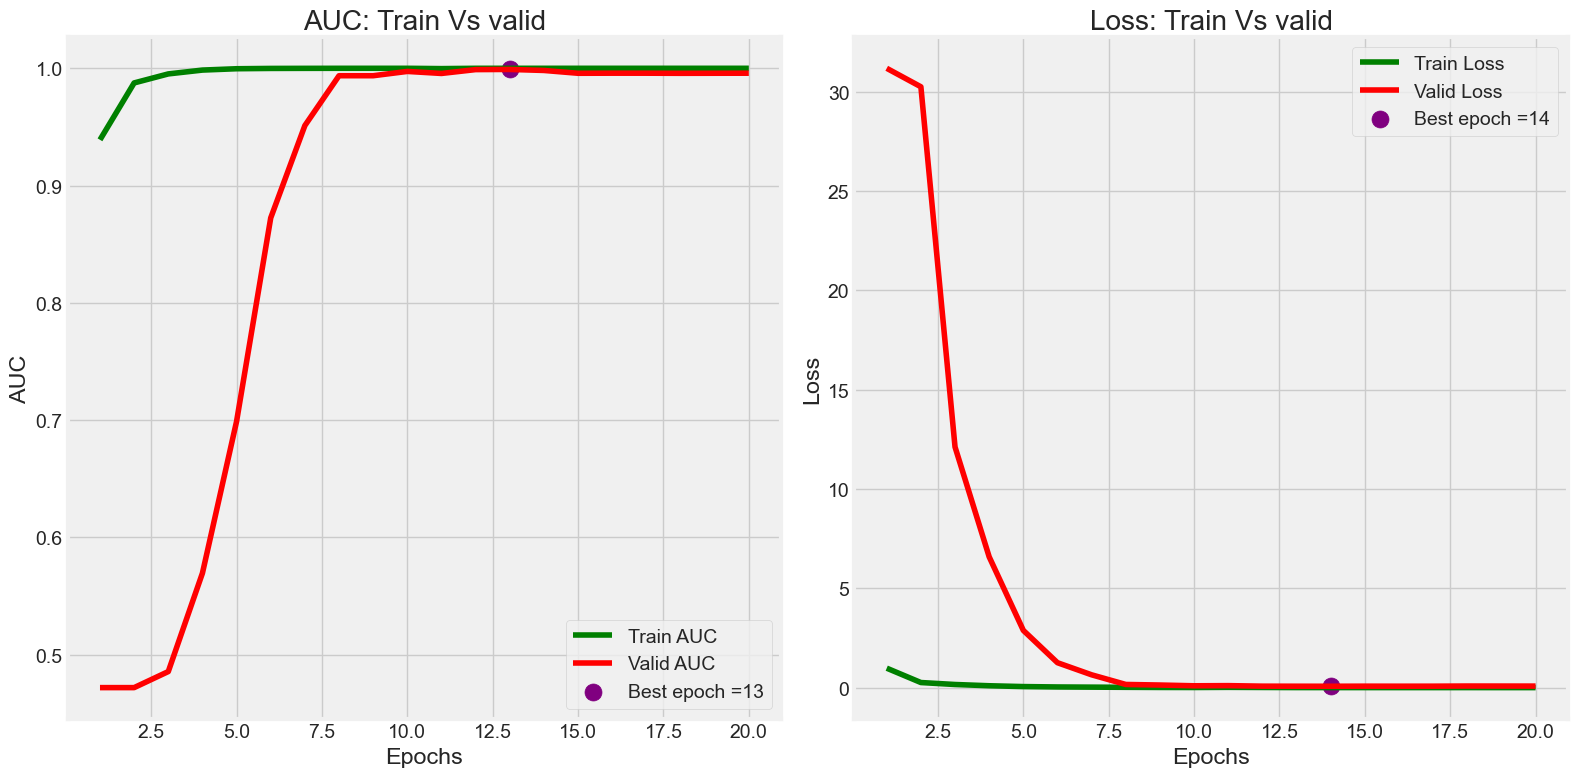

In [ ]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs, tr_auc, "g", label = "Train AUC")
plt.plot(Epochs, v_auc, "r", label = "Valid AUC")
plt.scatter(index_auc+1, high_Vauc, s= 150, color = 'purple', label = best_auc)

plt.title("AUC: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss_auc, "g", label = "Train Loss")
plt.plot(Epochs, v_loss_auc, "r", label = "Valid Loss")
plt.scatter(index_loss_auc+1, low_Vloss_auc, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.models import Model

In [ ]:
#save_model(model, 'accuracy_cnn_model.h5')

In [ ]:
save_model(model, 'auc_cnn_model.keras')

In [ ]:
# Kaydedilen modeli yükle
loaded_model = load_model('auc_cnn_model.keras')

In [ ]:
tr_loss,tr_auc = loaded_model.evaluate(train)
print("Auc Train Data: ",tr_auc)
print("Loss Train Data: ",tr_loss)

loss,auc = loaded_model.evaluate(test)
print("Auc Test Data: ",auc)
print("Loss Test Data: ",loss)

90/90 [==============================] - 68s 744ms/step - loss: 4.4279e-04 - auc: 1.0000
Auc Train Data:  1.0
Loss Train Data:  0.0004427944659255445
11/11 [==============================] - 8s 682ms/step - loss: 0.1026 - auc: 0.9969
Auc Test Data:  0.9969295263290405
Loss Test Data:  0.10259935259819031


In [ ]:
preds = loaded_model.predict_generator(test)
y_pred = np.argmax(preds, axis=1)

/var/folders/6p/tndyssh91tld84fxwdsr2jcm0000gn/T/ipykernel_3083/3819651593.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = loaded_model.predict_generator(test)


In [ ]:
train_sc = model.evaluate(train, verbose=0)
valid_sc = model.evaluate(valid, verbose=0)
test_sc = model.evaluate(test, verbose=0)
print(train_sc)
print(valid_sc)
print(test_sc)

In [ ]:
y_pred

array([2, 0, 1, 3, 2, 0, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 2, 1, 1, 2, 1, 3,
       3, 3, 1, 2, 3, 1, 3, 2, 3, 3, 2, 2, 0, 3, 1, 1, 1, 3, 3, 2, 2, 1,
       0, 0, 0, 2, 2, 1, 3, 2, 2, 0, 3, 0, 2, 1, 3, 2, 1, 1, 2, 2, 2, 1,
       0, 2, 1, 2, 3, 1, 3, 1, 1, 3, 2, 2, 1, 0, 0, 2, 2, 2, 0, 3, 0, 3,
       0, 2, 1, 3, 0, 3, 0, 0, 0, 1, 2, 2, 3, 2, 2, 1, 0, 2, 3, 0, 2, 2,
       3, 0, 0, 3, 2, 1, 2, 0, 1, 0, 1, 2, 1, 2, 3, 2, 1, 3, 3, 2, 3, 0,
       3, 2, 0, 3, 1, 0, 0, 1, 2, 2, 3, 0, 3, 1, 0, 1, 0, 0, 3, 3, 0, 2,
       2, 3, 2, 2, 2, 3, 2, 3, 2, 3, 0, 0, 1, 1, 3, 3, 3, 3, 1, 3, 3, 2,
       3, 0, 1, 1, 1, 3, 3, 3, 0, 1, 3, 3, 2, 3, 1, 3, 0, 1, 2, 2, 3, 3,
       3, 0, 3, 2, 1, 2, 1, 3, 3, 2, 3, 3, 1, 0, 3, 2, 2, 3, 2, 2, 2, 0,
       3, 0, 2, 2, 1, 2, 3, 1, 3, 0, 1, 0, 1, 2, 1, 2, 0, 3, 2, 2, 1, 2,
       2, 3, 3, 0, 2, 0, 2, 2, 1, 2, 0, 0, 0, 0, 1, 3, 2, 3, 2, 3, 0, 0,
       0, 1, 0, 2, 1, 1, 3, 3, 2, 3, 1, 2, 2, 2, 1, 1, 1, 0, 0, 2, 0, 1,
       1, 3, 1, 1, 2, 3, 0, 0, 2, 3, 1, 2, 0, 1, 1,

In [ ]:
cm = confusion_matrix(test.classes, y_pred)
cm

array([[128,  10,   0,   1],
       [  4, 145,   3,   1],
       [  0,   0, 200,   0],
       [  0,   1,   0, 163]])

In [ ]:
Test_cl_ind = test.class_indices
classes = list(Test_cl_ind.keys())

In [ ]:
predictions = model.predict_generator(test)
y_pred = np.argmax(predictions, axis=1)

print(predictions)
print(y_pred)

cm = confusion_matrix(test.classes, y_pred)
cm

/var/folders/6p/tndyssh91tld84fxwdsr2jcm0000gn/T/ipykernel_3083/3360449158.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test)


[[4.0979390e-12 7.5422045e-06 9.9998689e-01 5.6497988e-06]
 [9.5335102e-01 5.3293836e-05 1.3458255e-08 4.6595719e-02]
 [6.2290323e-03 9.9376655e-01 3.3388410e-06 1.0286566e-06]
 ...
 [3.4194383e-17 9.9539906e-01 4.6009249e-03 6.7510200e-14]
 [2.3854207e-07 1.5600565e-06 7.4504030e-08 9.9999809e-01]
 [9.9999928e-01 2.1869344e-07 4.7845458e-07 6.9385979e-13]]
[2 0 1 3 2 0 0 1 2 1 1 2 0 0 0 0 2 1 1 2 1 3 3 3 1 2 3 1 3 2 3 3 2 2 0 3 1
 1 1 3 3 2 2 1 0 0 0 2 2 1 3 2 2 0 3 0 2 1 3 2 1 1 2 2 2 1 0 2 1 2 3 1 3 1
 1 3 2 2 1 0 0 2 2 2 0 3 0 3 0 2 1 3 0 3 0 0 0 1 2 2 3 2 2 1 0 2 3 0 2 2 3
 0 0 3 2 1 2 0 1 0 1 2 1 2 3 2 1 3 3 2 3 0 3 2 0 3 1 0 0 1 2 2 3 0 3 1 0 1
 0 0 3 3 0 2 2 3 2 2 2 3 2 3 2 3 0 0 1 1 3 3 3 3 1 3 3 2 3 0 1 1 1 3 3 3 0
 1 3 3 2 3 1 3 0 1 2 2 3 3 3 0 3 2 1 2 1 3 3 2 3 3 1 0 3 2 2 3 2 2 2 0 3 0
 2 2 1 2 3 1 3 0 1 0 1 2 1 2 0 3 2 2 1 2 2 3 3 0 2 0 2 2 1 2 0 0 0 0 1 3 2
 3 2 3 0 0 0 1 0 2 1 1 3 3 2 3 1 2 2 2 1 1 1 0 0 2 0 1 1 3 1 1 2 3 0 0 2 3
 1 2 0 1 1 2 0 2 1 2 3 1 2 1 1 2 0 1 2 2

array([[128,  10,   0,   1],
       [  4, 145,   3,   1],
       [  0,   0, 200,   0],
       [  0,   1,   0, 163]])

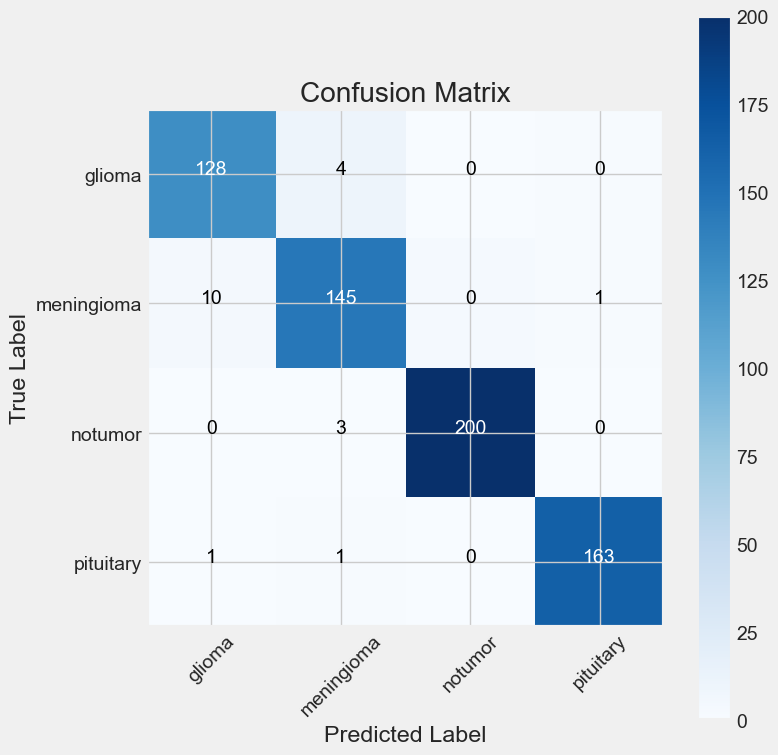

In [ ]:
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Özellik çıkarma katmanlarının belirlenmesi
#feature_extraction_model = Model(inputs=loaded_model.input, outputs=loaded_model.layers[-2].output)
feature_extraction_model = Model(inputs=loaded_model.input, outputs=loaded_model.get_layer('flatten_3').output)

feature_extraction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21_input (InputLaye  [(None, 224, 224, 3)]     0         
 r)                                                              
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 32)      128       
                                                                 
 batch_normalization_12 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_22 (Conv2D)          (None, 224, 224, 64)      2112      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                             

In [ ]:
# Eğitim ve test özelliklerini çıkartma
train_features = feature_extraction_model.predict(train)
test_features = feature_extraction_model.predict(test)

11/11 [==============================] - 7s 649ms/step


In [ ]:
#train_features = train_features.flatten()
#test_features = test_features.flatten()

In [ ]:
test_features
train_features

array([[-7.0000172e-01, -1.6980896e-03,  4.9911198e-01, ...,
        -6.6220808e-01,  1.5734049e+00,  1.0818055e+00],
       [-7.0000172e-01, -1.6980896e-03,  4.4730309e-01, ...,
         8.7748182e-01,  1.5691934e+00, -5.1793844e-01],
       [-7.0000172e-01, -1.6980896e-03, -3.4338713e-03, ...,
        -2.9878113e-01,  4.3931976e-01,  1.6087519e+00],
       ...,
       [-7.0000172e-01, -1.6980896e-03, -5.7213902e-01, ...,
        -6.6220808e-01, -6.9155407e-01, -3.9666143e-01],
       [-7.0000172e-01, -1.6980896e-03, -5.5217266e-01, ...,
         7.2656614e-01,  3.0885974e-01,  2.2218926e+00],
       [-7.0000172e-01, -1.6980896e-03, -7.1018124e-01, ...,
         1.0704076e+00,  1.4323668e-01,  1.8054035e+00]], dtype=float32)

In [ ]:
# Veri kümesindeki sınıfları sayısal değerlere dönüştürün
#label_encoder = LabelEncoder()
#df['encoded_labels'] = label_encoder.fit_transform(df['Label'])


In [ ]:
#test.labels

In [ ]:
#TRAIN DATA
batch_index=0
X_train_features=[]
y_train_one_hot=[]
while batch_index <= train.batch_index:
    data = train.next()
    for element in data[0]:
       X_train_features.append(feature_extraction_model.predict(np.array([element])).reshape(-1))
    for target in data[1]:
       y_train_one_hot.append(target)
    batch_index = batch_index + 1
del train
X_train_features=np.array(X_train_features)
y_train_one_hot=np.array(y_train_one_hot)
y_train=[]
for y in y_train_one_hot:
    y_train.append(np.argmax(y))

1/1 [==============================] - 0s 19ms/step


In [ ]:
#TEST DATA
X_test_features=[]
y_test_one_hot=[]
batch_index=0
while batch_index <= test.batch_index:
    data = test.next()
    for element in data[0]:
       X_test_features.append(feature_extraction_model.predict(np.array([element])).reshape(-1))
    for target in data[1]:
       y_test_one_hot.append(target)
    batch_index = batch_index + 1
del test
X_test_features=np.array(X_test_features)
y_test_one_hot=np.array(y_test_one_hot)
y_test=[]
for y in y_test_one_hot:
    y_test.append(np.argmax(y))

1/1 [==============================] - 0s 21ms/step


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, y_train)

In [ ]:
#y_predictions = knn.predict(X_test_features)
#y_predictions

In [ ]:
predictions = knn.predict_proba(test_features)

In [ ]:
predictions

array([[0. , 0. , 1. , 0. ],
       [0.2, 0. , 0. , 0.8],
       [0.2, 0.8, 0. , 0. ],
       ...,
       [0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 1. ],
       [1. , 0. , 0. , 0. ]])

In [ ]:
#test_labels

In [ ]:
auc_test = roc_auc_score(test_labels, predictions,multi_class='ovr')
print("ROC AUC score TEST: ",auc_test)

ROC AUC score TEST:  0.9887191983645534


In [ ]:
Test_cl_ind = test.class_indices
classes = list(Test_cl_ind.keys())
y_pred = np.argmax(predictions, axis=1)

knn_cm = confusion_matrix(test.classes, y_pred)
knn_cm

array([[127,   9,   0,   3],
       [ 13, 106,  18,  16],
       [  5,   0, 195,   0],
       [  0,   0,   0, 164]])

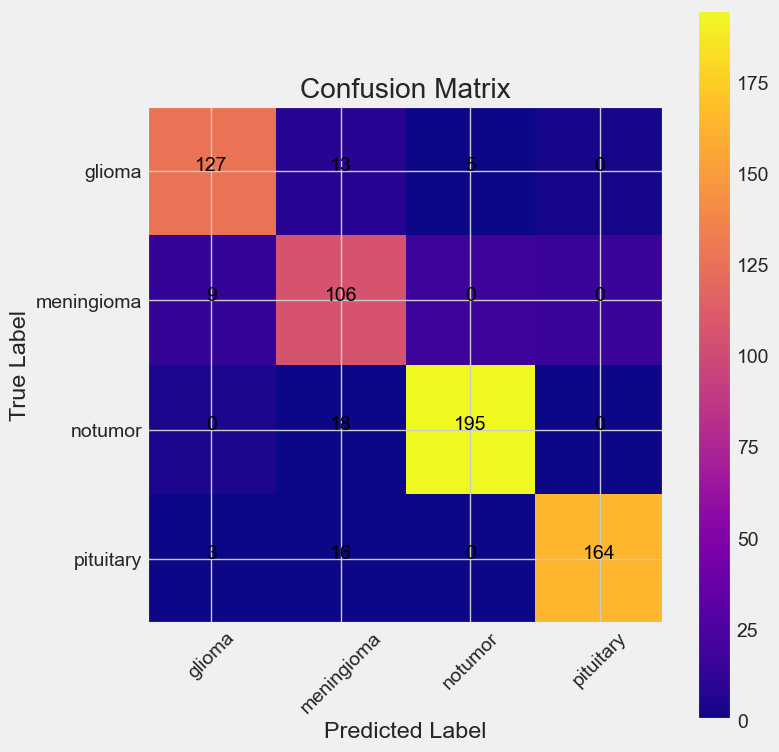

In [ ]:
plt.figure(figsize =(8, 8))
plt.imshow(knn_cm, interpolation = 'nearest', cmap = plt.cm.plasma)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)


thresh = knn_cm.max() / 2.
for i, j in itertools.product(range(knn_cm.shape[0]), range(knn_cm.shape[1])):
    plt.text(i, j, knn_cm[i, j], horizontalalignment= 'center', color= 'black' if knn_cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(test.classes, y_pred, target_names = classes))

              precision    recall  f1-score   support

      glioma       0.88      0.91      0.89       139
  meningioma       0.92      0.69      0.79       153
     notumor       0.92      0.97      0.94       200
   pituitary       0.90      1.00      0.95       164

    accuracy                           0.90       656
   macro avg       0.90      0.90      0.89       656
weighted avg       0.90      0.90      0.90       656
